Anomaly Detection Heuristics 
===

> This notebook reimplements and prints different heuristics from Nolle 2019 including
- elbow_up
- elbow_down
- lowest_plateau_left
- lowest_plateau_right
- lowest_plateau_centered
- best

> Additional we show the how prediction score normalization affects the anomaly ratio curve and leads to a performance boost im terms of F1-Score on the anomaly detection task

In [ ]:
#| default_exp anomaly.heuristics

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastai.basics import *
from pympp.process import *
from pympp.anomaly.detect import *
from sklearn.metrics import confusion_matrix
from fastai.tabular.model import get_emb_sz
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import seaborn as sns

## Get Anomaly Scores:

In [ ]:
#| export

# Custom F_Score of PDC Challenge:
def f_score(y_true, y_pred,sample_weight=None):
    C = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)
    with np.errstate(divide="ignore", invalid="ignore"):
        per_class = np.diag(C) / C.sum(axis=1)
    if np.any(np.isnan(per_class)):
        warnings.warn("y_pred contains classes not in y_true")
        per_class = per_class[~np.isnan(per_class)]
    P = per_class[0]
    N = per_class[1]
    score = 2*(P*N)/(P+N)
    return score

In [ ]:
#| export
def load_pred_model(learner_path,train_log_path,log_name,cols=['activity']):
    p = f'{learner_path}/{log_name}_vocab.p'
    with open(p, 'rb') as fp:
        categorify = pickle.load(fp)
    log = import_log(train_log_path)
    o = process_test(log,categorify,cols)
    dls=o.get_dls()
    loss=partial(multi_loss_sum,o)
    emb_szs = get_emb_sz(o)
    m=MultivariateModel(emb_szs)
    learn=Learner(dls, m, path=learner_path, model_dir='.', loss_func=loss, metrics=get_metrics(o))
    learn.load(log_name,with_opt=False)
    m=learn.model.cuda()
    return m, categorify

In [ ]:
#| export
def multivariate_anomaly_score(res,o,idx,cols,normalization = True):
    score_df=pd.DataFrame()

    for cidx,_ in enumerate(cols):
        sm = nn.Softmax(dim=1)
        p = sm(res[cidx].cpu())
        pred = p.max(1)[0]
        y = o.items[cols[cidx]].iloc[idx].values

        truth=p[list(range(len(y))),y]
        if normalization:
            score = ((pred - truth) / pred).tolist()
        else:
            score = (pred - truth).tolist()
        score_df[cols[cidx]] = score
    score_df['trace_id']=o.items.index.to_series().iloc[idx].values
    return score_df

In [ ]:
#| export
def get_score_df(log_name,prediction_normalization = True):
    learner_path=f'../models/pdc2020'
    training_log_path = f'../data/logs/csv/dapnn_ds/PDC2020_training/pdc_2020_{log_name}.csv.gz'
    test_log_path = f'../data/logs/csv/dapnn_ds/PDC2020_ground_truth/pdc_2020_{log_name}.csv.gz' 
    
    cols = ['activity']
    m, categorify= load_pred_model(learner_path,training_log_path,f"pdc_2020_{log_name}")
    if type(test_log_path)==str:
        log = import_log_pdc(test_log_path)
    else:
        log = test_log_path   
    o = process_test(log,categorify,cols)
    nsp,idx=predict_next_step(o,m)
    score_df=multivariate_anomaly_score(nsp,o,idx,cols,prediction_normalization)
    y_true =o.items['normal'].astype(float).groupby(o.items.index).mean().to_numpy() ==False
    return score_df, y_true

In [ ]:
log_name = '1001001'
score_df, y_true = get_score_df(log_name)
score_df

,activity,trace_id
0,0.000000,trace 1
1,0.000000,trace 1
2,0.052144,trace 1
3,0.000000,trace 1
4,0.121892,trace 1
...,...,...
12992,0.000000,trace 1000
12993,0.000000,trace 1000
12994,0.000000,trace 1000
12995,0.000000,trace 1000


## Get Predictions per threshold

In [ ]:
#| export
def get_preds(score_df,threshold):
    h =score_df.groupby('trace_id')['activity'].max()
    h=(h-h.min())/(h.max()-h.min())

    y_pred = (h.to_numpy()>threshold).astype(int)
    return y_pred


In [ ]:
ths = np.array((range(1000)))*0.001 +0.0
ths[:20]

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019])

In [ ]:
#| export
def get_th_df(ths,score_df,y_true,log_name,f_score=f_score):
    res = []
    for t in progress_bar(ths):
        y_pred=get_preds(score_df,t)
        anomaly_ratio = sum(x == 1 for x in y_pred) / len(y_pred)
        f1 = f_score(y_true, y_pred)
        precision = precision_score(y_true,y_pred)
        recall = recall_score(y_true,y_pred)
        res.append([log_name, f1, precision, recall, anomaly_ratio])

    columns='Log Name', 'F1 Score','Precision','Recall', 'Anomaly Ratio'
    th_df = pd.DataFrame(res,columns=columns,index=ths)
    return th_df


In [ ]:
th_df = get_th_df(ths,score_df,y_true,log_name)
th_df

,Log Name,F1 Score,Precision,Recall,Anomaly Ratio
0.000,1001001,0.003914,0.489980,0.997959,0.998
0.001,1001001,0.003914,0.489980,0.997959,0.998
0.002,1001001,0.003914,0.489980,0.997959,0.998
0.003,1001001,0.003914,0.489980,0.997959,0.998
0.004,1001001,0.003914,0.489980,0.997959,0.998
...,...,...,...,...,...
0.995,1001001,0.775937,0.996795,0.634694,0.312
0.996,1001001,0.743047,0.996564,0.591837,0.291
0.997,1001001,0.716772,0.996364,0.559184,0.275
0.998,1001001,0.657110,0.995851,0.489796,0.241


## Heuristics

Best Threshold

In [ ]:
#| export
def get_best_threshhold(th_df): return th_df.iloc[th_df['F1 Score'].argmax()]


In [ ]:
best_threshhold = get_best_threshhold(th_df)
best_threshhold

Log Name          1001001
F1 Score         0.953093
Precision        0.943888
Recall           0.961224
Anomaly Ratio       0.499
Name: 0.9430000000000001, dtype: object

Fixed Threshold

In [ ]:
#| export
def get_fixed_heuristic(fixed,th_df): return th_df.iloc[np.absolute(th_df.index.to_numpy()-fixed).argmin()]


In [ ]:
fixed = 0.98

fixed_heuristic =get_fixed_heuristic(fixed,th_df)
fixed_heuristic

Log Name          1001001
F1 Score         0.932661
Precision         0.97973
Recall           0.887755
Anomaly Ratio       0.444
Name: 0.98, dtype: object

Ratio Heuristic

In [ ]:
#| export
def get_ratio_th(ratio,th_df):return th_df.iloc[th_df['Anomaly Ratio'].sub(ratio).abs().argmin()]


In [ ]:
ratio =0.5
ratio_heuristic =get_ratio_th(ratio,th_df)
ratio_heuristic

Log Name          1001001
F1 Score         0.953093
Precision        0.943888
Recall           0.961224
Anomaly Ratio       0.499
Name: 0.9430000000000001, dtype: object

In [ ]:
half_ratio = partial(get_ratio_th,0.5)
half_ratio(th_df)

Log Name          1001001
F1 Score         0.953093
Precision        0.943888
Recall           0.961224
Anomaly Ratio       0.499
Name: 0.9430000000000001, dtype: object

Ellbow Heuristic

In [ ]:
#| export
def elbow_heuristic(th_df):
    taus = th_df.index.to_numpy()
    r = th_df['Anomaly Ratio'].to_numpy()
    step = taus[1:] - taus[:-1]
    r_prime_prime = (r[2:] - 2 * r[1:-1] + r[:-2]) / (step[1:] * step[:-1])
    ellbow_down = th_df.iloc[np.argmax(r_prime_prime) + 1]
    ellbow_up = th_df.iloc[np.argmin(r_prime_prime) + 1]
    return ellbow_down,ellbow_up


In [ ]:
ellbow_down,ellbow_up = elbow_heuristic(th_df)
ellbow_down,ellbow_up

(Log Name          1001001
 F1 Score         0.820048
 Precision        0.760188
 Recall           0.989796
 Anomaly Ratio       0.638
 Name: 0.6880000000000001, dtype: object,
 Log Name          1001001
 F1 Score          0.65711
 Precision        0.995851
 Recall           0.489796
 Anomaly Ratio       0.241
 Name: 0.998, dtype: object)

Lowest Plateau Heuristic

In [ ]:
#| export
def get_lowest_plateau_heuristic(th_df):
    taus = th_df.index.to_numpy()
    r = th_df['Anomaly Ratio'].to_numpy()
    r_prime = (r[1:] - r[:-1]) / (taus[1:] - taus[:-1])
    stable_region = r_prime > np.mean(r_prime) / 2
    regions = np.split(np.arange(len(stable_region)), np.where(~stable_region)[0])
    regions = [taus[idx[1:]] for idx in regions if len(idx) > 1]
    if len(regions) == 0:
        regions = [taus[-2:]]
    lp_min = get_fixed_heuristic(regions[-1].min(),th_df)
    lp_mean = get_fixed_heuristic(regions[-1].mean(),th_df)
    lp_max = get_fixed_heuristic(regions[-1].max(),th_df)
    return lp_min,lp_mean,lp_max


In [ ]:
lp_min,lp_mean,lp_max=get_lowest_plateau_heuristic(th_df)
lp_min,lp_mean,lp_max

(Log Name          1001001
 F1 Score         0.941795
 Precision        0.977974
 Recall           0.906122
 Anomaly Ratio       0.454
 Name: 0.975, dtype: object,
 Log Name          1001001
 F1 Score         0.941795
 Precision        0.977974
 Recall           0.906122
 Anomaly Ratio       0.454
 Name: 0.975, dtype: object,
 Log Name          1001001
 F1 Score         0.941795
 Precision        0.977974
 Recall           0.906122
 Anomaly Ratio       0.454
 Name: 0.975, dtype: object)

## Visualization


In [ ]:
log_name = '1001001'
score_df,y_true = get_score_df(log_name)
ths = np.array((range(100)))*0.001 +0.9
th_df = get_th_df(ths,score_df,y_true,log_name)
heuristics = [get_best_threshhold,partial(get_ratio_th,0.5),elbow_heuristic,
              partial(get_fixed_heuristic,0.98),get_lowest_plateau_heuristic]
heuristic_names = ['best','r_0.5','e_down','e_up','fix','lp_min','lp_mean','lp_max']
heuristic_scores =[i for j in [listify(x(th_df)) for x in heuristics] for i in j]

In [ ]:
#export
def get_plot_data(th_df,id_vars=['Log Name'],value_vars = ['F1 Score','Anomaly Ratio']):
    plot_data=th_df.melt(var_name='Metric',value_name='Score',id_vars =id_vars ,value_vars=value_vars,ignore_index=False)
    plot_data['Threshold']=plot_data.index
    plot_data.index=range(len(plot_data))
    return plot_data


In [ ]:
plot_data = get_plot_data(th_df)

<matplotlib.legend.Legend>

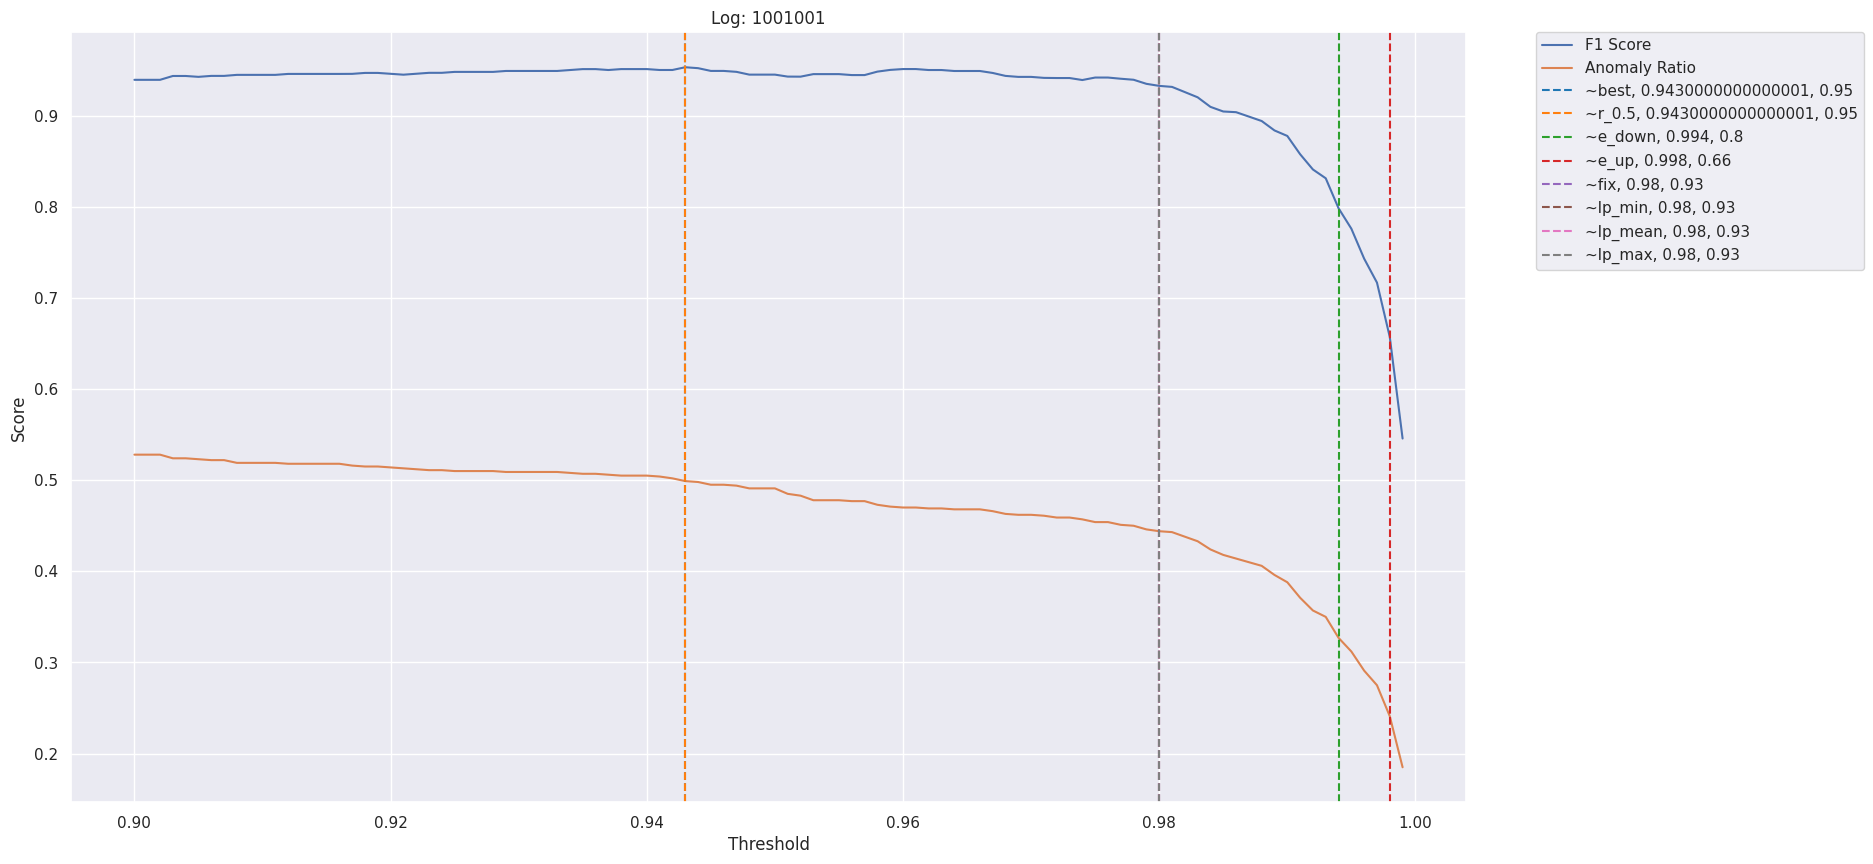

In [ ]:
color_palette = sns.color_palette()
sns.set(rc={'figure.figsize':(18,10)})

sns.lineplot(x="Threshold", y="Score",
             hue="Metric",
             data=plot_data).set(title=f'Log: {log_name}')
for i in range(len(heuristic_scores)):
    plt.axvline(heuristic_scores[i].name, 0,1,color=color_palette[i],linestyle='--',
                label=f"~{heuristic_names[i]}, {heuristic_scores[i].name}, {heuristic_scores[i]['F1 Score'].round(2)}")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [ ]:
pd.DataFrame(zip([i.name for i in heuristic_scores],[i['F1 Score'] for i in heuristic_scores]),
             columns=['Threshold','F1-Score'],index=heuristic_names)

,Threshold,F1-Score
best,0.943,0.953093
r_0.5,0.943,0.953093
e_down,0.994,0.798393
e_up,0.998,0.657110
fix,0.980,0.932661
lp_min,0.980,0.932661
lp_mean,0.980,0.932661
lp_max,0.980,0.932661


## Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()